# Introduction

The following notebook is meant to visualise the steps taken to automatically register probes from probeinterface to histology dye stains.



In [1]:
# Setup
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from importlib import reload
from pathlib import Path

#make sure your current working directory is .../path/to/code
# where brainreg_probe is in code/brainreg_probe
from brainreg_probe import probeinterface_tracing as pit
from brainreg_probe import run_brainreg as rub
from brainreg_probe import plot_util_func as puf

## STEP 1: running brainreg
 
before running brain registraton we need to double-check **the orientation of the data**.

>In the saved notebook, for each subject we see slices of brainstem and cerebellum, so the first axis is posterior-anterior. 
>The top-left corner (marked in red) is therefore the superior left corner. Thus all subjects are oriented as `psl` in this dataset.
>
>Make sure to state the orientation in the `run_brainreg.py` script before running the run_brainreg() function.

Also make sure that **the assignment of `SIGNAL_CHANNEL` and `REGISTRATION_CHANNEL`** is in accordance with the dye used and the imaging channels.
By default we assume a Dil dye is used, which fluoresces in the orange-red spectrum. We assume that channel 2 is red and use channel 3 (green) as a reference channel for brain registration.




Saved plot to: ../data/preprocessed_data/brainreg/EX01/orientation_check.png


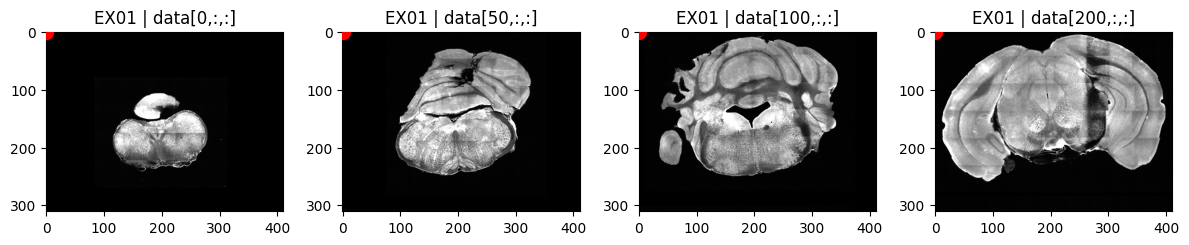

Saved plot to: ../data/preprocessed_data/brainreg/EX03/orientation_check.png


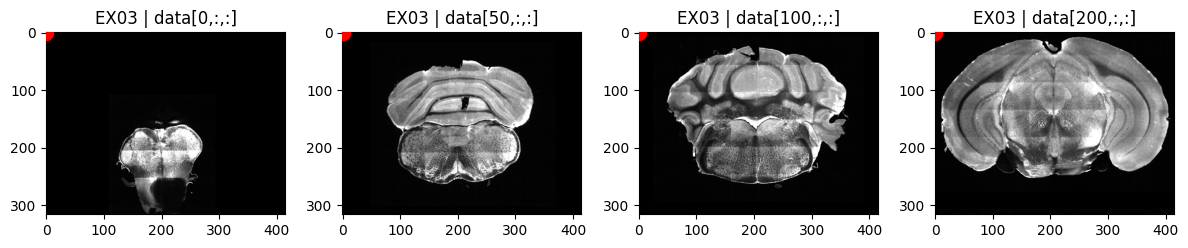

Saved plot to: ../data/preprocessed_data/brainreg/EX06/orientation_check.png


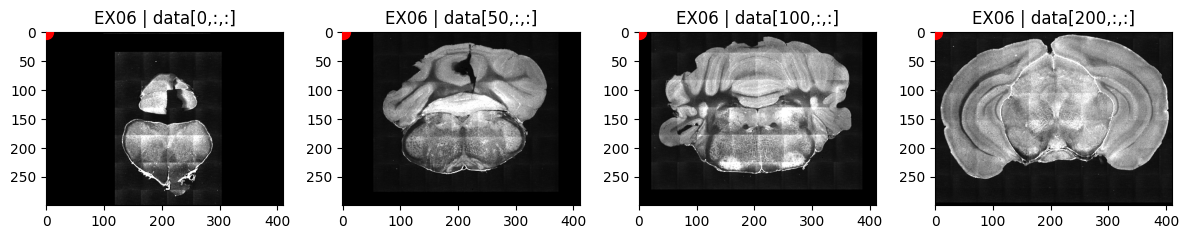

Saved plot to: ../data/preprocessed_data/brainreg/EX04/orientation_check.png


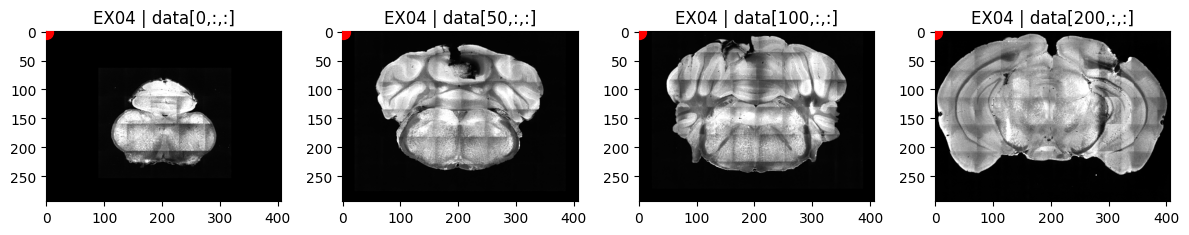

Saved plot to: ../data/preprocessed_data/brainreg/EX08/orientation_check.png


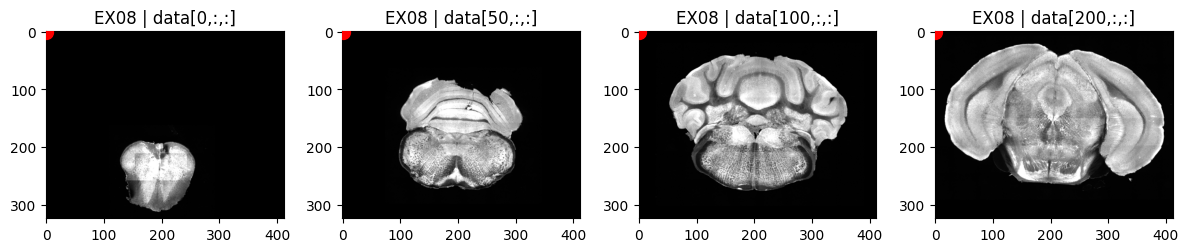

In [2]:
# check brain orientations
rub.check_brain_orientations()


In [ ]:
#uncomment below to run brainreg! 
#rub.run_brainreg(overwrite=True) #NB: this will send jobs to the cluster

## Step 2: mapping a probe to signal data

Here we map the signal data to our probe geometry.




(
)

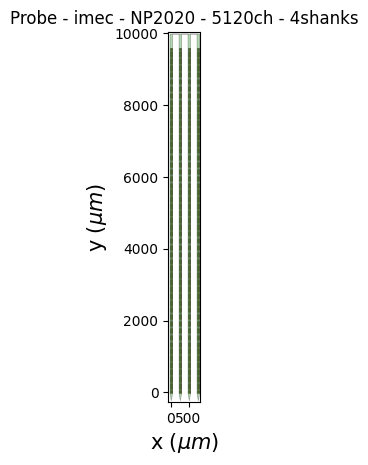

In [10]:
# Probe interface example
import probeinterface as pi
from probeinterface.plotting import plot_probe, plot_probe_group

test_probe = pi.get_probe(manufacturer='imec',probe_name='NP2020')
plot_probe(test_probe)


Fitting probe to data from EX08
Loading data...
Thresholding signal...
Clustering signal (20744 points) into 2 clusters...


100%|██████████| 20/20 [00:47<00:00,  2.38s/it]


Found 1 clusters too many. Assuming smallest cluster(s) to be noise and ignoring.
Fitting ProbeA to signal data...
Fitting ProbeB to signal data...
Saved section plots to:
 ../data/preprocessed_data/brainreg/EX08/ProbeA_sections.png
Saved section plots to:
 ../data/preprocessed_data/brainreg/EX08/ProbeB_sections.png


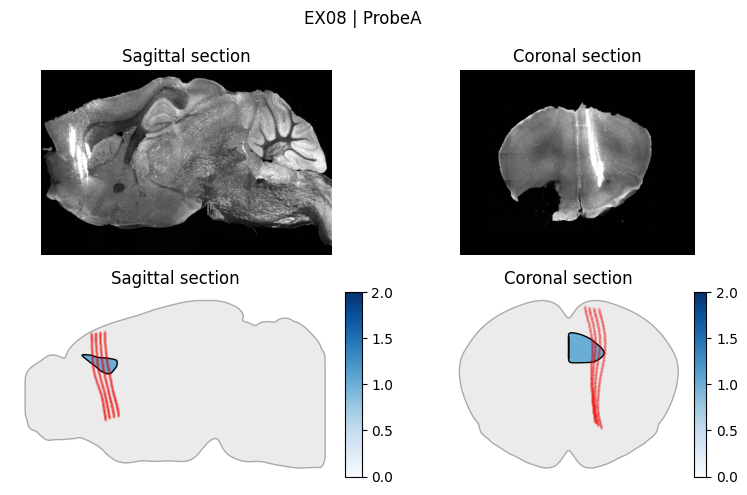

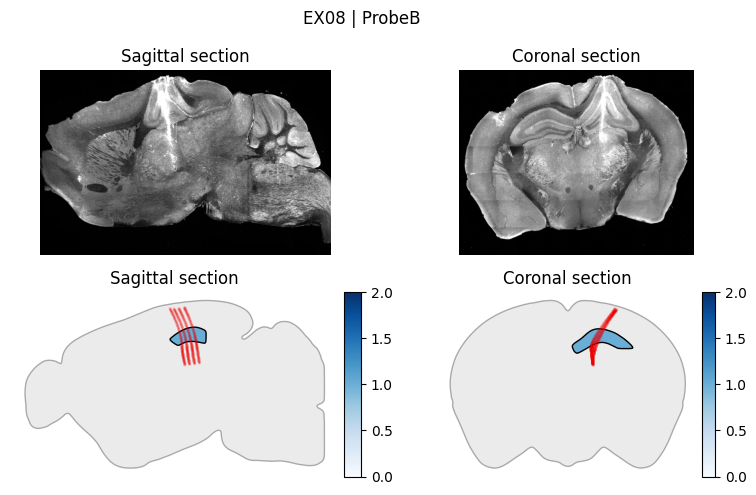

In [12]:
reload(pit)

pit.run_probeinterface_tracking(subject_IDs=['EX08'])

In [3]:
# Wrap up the section data as a little pdf
from PIL import Image
images = []
for subfolder in rub.PREPROCESSED_BRAINREG_PATH.iterdir():
    for each_file in subfolder.iterdir():
        if 'sections' in each_file.stem:
            images.append(Image.open(each_file))

pdf_path = '../results/histology/all_probe_sections.pdf'
images[0].save(pdf_path,"PDF",resolution=100.0, save_all=True, append_images=images[1:])

In [ ]:
#this should be as easy as:
from brainreg_probe import probeinterface_tracing as pit; reload(pit)
subject_ID = 'EX08'
brainreg_atlas_path = pit.PREPROCESSED_BRAINREG_PATH/subject_ID/pit.ATLAS_NAME
input_dict = pit.EXAMPLE_INPUT_DICT
probe_dfs, fit_params, signal_df, data = pit.get_probe_registration_df(brainreg_atlas_path, input_dict)

## Probefitting methodological details

Here we slowly run things line-by-line and with visualisations to show what's going on behind the scenes. This may also be helpful for debugging later.

In [19]:
# here we essintially unwrap the get_probes_df function
import pandas as pd
import json
from brainreg_probe import probeinterface_tracing as pit; reload(pit)
subject_ID = 'EX08'
brainreg_atlas_path = pit.PREPROCESSED_BRAINREG_PATH/subject_ID/pit.ATLAS_NAME
input_dict= pit.EXAMPLE_INPUT_DICT
input_dict['fixed_depths'] = [None,380]
#### get_probe_registration_df() ####
probe_info = input_dict['probe_info']
n_probes = len(probe_info)
print('Loading data...')
data = pit.get_data(brainreg_atlas_path, 
                signal_channel = input_dict['brainreg_signal_channel'])
print(f'Thresholding signal...')
threshold_signal = pit.threshold_signal_gamma(data['signal_data'])
signal_df = pit.make_signal_df(data['signal_data'], threshold_signal)
print(f'Clustering signal ({len(signal_df)} points) into {n_probes} clusters...')
signal_df = pit.cluster_signal(signal_df, n_clusters=n_probes)
signal_df = pit.reorder_signal_clusters(signal_df,input_dict['probe_ordering_axis'])
surface_df = pit.get_surface_coord_df(data['boundaries'])
# Get ready to rumble:
probe_dfs = []
fit_params = []
for each_probe in range(n_probes):
    probe_df = pit.get_probe_contacts_df(probe_info[each_probe]['manufacturer'],
                                        probe_info[each_probe]['name'])
    longer_than_wider = probe_df['probe_coords.y'].max()>probe_df['probe_coords.x'].max()
    probe_signal_df = signal_df[signal_df['cluster']==each_probe]
    print(f"Fitting {probe_info[each_probe]['label']} to signal data...")
    fitted_plane = pit.fit_plane_to_signal(probe_signal_df,
                                        input_dict['insertion_axis'][each_probe],
                                        input_dict['contact_face_axis'][each_probe],
                                        longer_than_wider)
    fitted_plane = pit.append_surface_coord(surface_df,fitted_plane)
    initial_params = pit.estimate_initial_params(probe_signal_df,probe_df,fitted_plane)
    if input_dict['fixed_depths'][each_probe] is not None:
        initial_params = pit.estimate_initial_params(signal_df,probe_df, fitted_plane,
                                                    probe_depth = input_dict['fixed_depths'][each_probe])
    best_params_dict = pit.optimize_probe_plane(probe_signal_df,probe_df,fitted_plane, initial_params)
    transformed_points = pit.transform_2d_probe(probe_df, best_params_dict.values())
    downsampled_coords = pit.project_2d_points_to_plane(transformed_points, fitted_plane)
    atlas_coords = pit.sample_coords_to_allen_space(downsampled_coords.values, data)
    #return the coordinates in downsampled space 
    
    #now append coords to the dataframe
    probe_df = probe_df[probe_df['probe_coords.y']<best_params_dict['probe_depth']]
    for coord_type, coords_data in {'downsample_coords':downsampled_coords.values,'allen_atlas_coords':atlas_coords}.items():
            for idx, coord in enumerate(['i','j','k']):
                probe_df[f'{coord_type}.{coord}'] = coords_data[:,idx]
    # append the anatomy data
    anatomy_dict = pit.get_structure_labels(downsampled_coords.values, data)
    for label, structure_data in anatomy_dict.items():
        probe_df[f'structure.{label}'] = structure_data
    # add probe name to data
    probe_df['probe_name'] = probe_info[each_probe]['label']
    best_params_dict['probe_name'] = probe_info[each_probe]['label']
    best_params_dict.update({k:list(v) for k,v in fitted_plane.items()})

    #save out the data
    probe_df_path = (brainreg_atlas_path.parent)/f"{probe_info[each_probe]['label']}_anatomy.htsv"
    probe_df.to_csv(probe_df_path,sep='\t', index=False)
    params_path = (brainreg_atlas_path.parent)/f"{probe_info[each_probe]['label']}_fit_params.json"
    with open(params_path, "w") as f:      #below we make np.arrays() lists for saving
        json.dump(best_params_dict, f, indent = 4)
    #append to lists
    #make probe_df multiindex before outputting
    probe_df.columns = pd.MultiIndex.from_tuples([col.split('.') if '.' in col else (col,'') for col in probe_df.columns])
    probe_dfs.append(probe_df[['probe_coords','downsample_coords','allen_atlas_coords','structure']]) #simple reordering of columns here.. nothing to see
    fit_params.append(best_params_dict)

## PLOTTING ##
from brainreg_probe import plot_util_func as puf
import numpy as np
reload(puf); reload(pit)
for idx, probe_df in enumerate(probe_dfs):
    fig, ax = puf.plt.subplots(2,2, figsize = (8,5), width_ratios=[1.5,1])
    fig.suptitle(f"{subject_ID} | {fit_params[idx]['probe_name']}")
    _ = puf.plot_sample_data_sections(data['signal_data'],
                                        fit_params[idx]['centroid'],
                                        fig_and_axes=(fig,[ax[0][0],ax[0][1]]))
    allen_plane_centroid = pit.sample_coords_to_allen_space([fit_params[idx]['centroid']],
                                                            data)[0]
    _ = puf.plot_atlas_data_sections(probe_df.allen_atlas_coords.values,
                                        allen_plane_centroid,
                                        fig_and_axes = (fig,[ax[1][0],ax[1][1]]),
                                        highlight_region=input_dict['target_regions'][idx])
    fig_path = pit.PREPROCESSED_BRAINREG_PATH/subject_ID/f"{fit_params[idx]['probe_name']}_sections.png"
    fig.savefig(fig_path)


Loading data...
Thresholding signal...
Clustering signal (20744 points) into 2 clusters...


100%|██████████| 20/20 [00:36<00:00,  1.82s/it]


Found 1 clusters too many. Assuming smallest cluster(s) to be noise and ignoring.
Fitting ProbeA to signal data...
Fitting ProbeB to signal data...


TypeError: estimate_initial_params() got an unexpected keyword argument 'probe_depth'

In [16]:
initial_params


{
    'probe_depth': np.float64(38000.0),
    'brain_shrinkage_pct': np.float64(0.0),
    'probe_width_scaling': np.float64(1.0),
    'theta': 0.001,
    'offset_x': 1
}

### Methods plots one-by-one


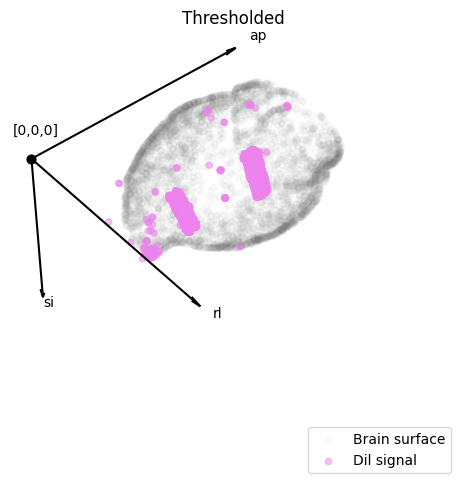

In [14]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(1, 1, 1, projection='3d')

subsampled_surface = surface_df.sample(5000)

# Plot the brain surface
ax1.scatter(subsampled_surface.k,
            subsampled_surface.i,
            subsampled_surface.j,
            color='gray', alpha=0.03,
            label='Brain surface')

# Plot the signal
ax1.scatter(signal_df.k, signal_df.i, signal_df.j,
            color='violet', alpha=0.5,
            label='Dil signal')

ax1.set_title('Thresholded')

# --- Get limits to know how long arrows should be ---
x_limits = ax1.get_xlim3d()
y_limits = ax1.get_ylim3d()
z_limits = ax1.get_zlim3d()

# Make all axes the same length
def set_equal_aspect_3d(ax):
    """Force equal aspect ratio on 3D axes (so arrows are not squashed)."""
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    y_range = abs(y_limits[1] - y_limits[0])
    z_range = abs(z_limits[1] - z_limits[0])

    max_range = max(x_range, y_range, z_range)

    # Center everything around the origin
    ax.set_xlim3d([0, max_range])
    ax.set_ylim3d([0, max_range])
    ax.set_zlim3d([0, max_range])
    return max_range
max_range = set_equal_aspect_3d(ax1)

# Arrow lengths
x_len = max_range * 0.9
y_len = max_range * 0.9
z_len = max_range * 0.9

# Draw arrows from origin
ax1.quiver(0, 0, 0, x_len, 0, 0, color='k', arrow_length_ratio=0.05)
ax1.quiver(0, 0, 0, 0, y_len, 0, color='k', arrow_length_ratio=0.05)
ax1.quiver(0, 0, 0, 0, 0, z_len, color='k', arrow_length_ratio=0.05)

# Add axis labels at arrow tips
ax1.text(x_len+100, 0, 0, 'rl', color='k')
ax1.text(0, y_len+100, 0, 'ap', color='k')
ax1.text(0, 0, z_len+100, 'si', color='k')

# Add origin
ax1.scatter(0, 0, 0, c='black', s=40, marker='o')
ax1.text(0, -100, -300, '[0,0,0]', color='black')
ax1.invert_zaxis()

# Rotate view
ax1.view_init(elev=45, azim=-40)

# Add legend
ax1.legend(loc='lower right')

# Turn off default axes/background
ax1.axis('off')

plt.tight_layout()
plt.show()


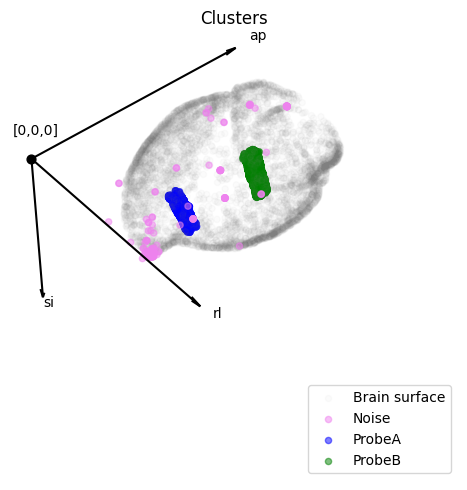

In [15]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(1, 1, 1, projection='3d')

subsampled_surface = surface_df.sample(5000)

# Brain surface (gray)
ax1.scatter(subsampled_surface.k,
            subsampled_surface.i,
            subsampled_surface.j,
            color='gray', alpha=0.03,
            label='Brain surface')

# --- Plot signal by cluster: -1 -> violet, 0 -> blue, 1 -> green ---
cluster_colors = { -1: 'violet', 0: 'blue', 1: 'green' }
cluster_labels = { -1: 'Noise', 0: 'ProbeA', 1: 'ProbeB' }

for cid in [-1, 0, 1]:
    m = (signal_df['cluster'] == cid)
    if m.any():
        ax1.scatter(signal_df.loc[m, 'k'],
                    signal_df.loc[m, 'i'],
                    signal_df.loc[m, 'j'],
                    color=cluster_colors[cid], alpha=0.5,
                    label=cluster_labels[cid])

ax1.set_title('Clusters')

# --- Equal aspect & arrow-axes ---
def set_equal_aspect_3d(ax):
    """Force equal aspect ratio on 3D axes (so arrows are not squashed)."""
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    y_range = abs(y_limits[1] - y_limits[0])
    z_range = abs(z_limits[1] - z_limits[0])

    max_range = max(x_range, y_range, z_range)

    ax.set_xlim3d([0, max_range])
    ax.set_ylim3d([0, max_range])
    ax.set_zlim3d([0, max_range])
    return max_range

max_range = set_equal_aspect_3d(ax1)

# Arrows
arrow_len = max_range * 0.9
ax1.quiver(0, 0, 0, arrow_len, 0, 0, color='k', arrow_length_ratio=0.05)
ax1.quiver(0, 0, 0, 0, arrow_len, 0, color='k', arrow_length_ratio=0.05)
ax1.quiver(0, 0, 0, 0, 0, arrow_len, color='k', arrow_length_ratio=0.05)

# Axis labels at tips
ax1.text(arrow_len+100, 0, 0, 'rl', color='k')
ax1.text(0, arrow_len+100, 0, 'ap', color='k')
ax1.text(0, 0, arrow_len+100, 'si', color='k')

# Origin
ax1.scatter(0, 0, 0, c='black', s=40, marker='o')
ax1.text(0, -100, -300, '[0,0,0]', color='black')

# View & legend
ax1.view_init(elev=45, azim=-40)
ax1.legend(loc='lower right')

# Clean background
ax1.axis('off')
ax1.invert_zaxis()

plt.tight_layout()
plt.show()


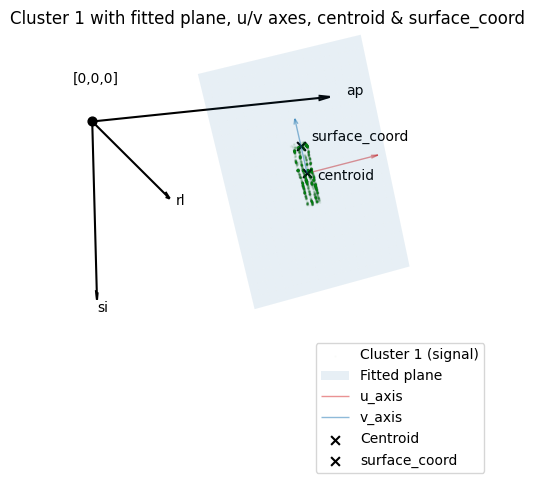

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# --- Inputs you already have ---
# probe_signal_df : DataFrame with columns k, i, j (cluster == 1 points)
# fitted_plane : dict with keys 'centroid', 'u_axis', 'v_axis', 'surface_coord'
#                each value can be list/tuple/np.array of length 3

centroid = np.asarray(fitted_plane['centroid'], dtype=float)
u_axis   = np.asarray(fitted_plane['u_axis'], dtype=float)
v_axis   = np.asarray(fitted_plane['v_axis'], dtype=float)
surf_pt  = np.asarray(fitted_plane['surface_coord'], dtype=float)

# Normalize u/v to get clean scaling
u = u_axis #/ np.linalg.norm(u_axis)
v = v_axis #/ np.linalg.norm(v_axis)

# Cluster 1 points
pts = probe_signal_df[['k', 'i', 'j']].to_numpy(dtype=float)

# Project cluster points onto the plane axes to size the mesh nicely
rel = pts - centroid
u_coords = rel @ u
v_coords = rel @ v

# Span of the plane: a bit larger than the cluster extent in-plane
u_span = max(1e-6, np.max(np.abs(u_coords))) * 1.2
v_span = max(1e-6, np.max(np.abs(v_coords))) * 1.2

uu = np.linspace(-u_span, u_span, 20)
vv = np.linspace(-v_span, v_span, 20)
UU, VV = np.meshgrid(uu, vv)
plane_xyz = centroid + UU[..., None] * u + VV[..., None] * v

# --- Figure ---
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(1, 1, 1, projection='3d')

# Cluster 1 points (green)
ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2],
           color='green', alpha=0.01, s=1, label='Cluster 1 (signal)',zorder=1)

# Plane mesh
ax.plot_surface(plane_xyz[..., 2], plane_xyz[..., 0], plane_xyz[..., 1],
                alpha=0.1, label='Fitted plane')

# u / v axis vectors (from centroid)
axis_len = 0.9 * min(u_span, v_span)
ax.quiver(centroid[2], centroid[0], centroid[1],
          *(u[[2,0,1]] * axis_len), color='tab:red', 
          alpha=0.5, linewidth=1, label='u_axis',
           arrow_length_ratio=0.1)
ax.quiver(centroid[2], centroid[0], centroid[1],
          *(v[[2,0,1]] * axis_len), color='tab:blue', 
          alpha = 0.5, linewidth=1, label='v_axis',
          arrow_length_ratio = 0.1)

# Centroid & surface_coord
ax.scatter(centroid[2],centroid[0],centroid[1], c='k', s=40, marker='x', label='Centroid')
ax.text(*([centroid[2],centroid[0],centroid[1]] + 0.1 * axis_len), 'centroid', color='k')
ax.scatter(surf_pt[2],surf_pt[0],surf_pt[1], marker = 'x', c='k', s=40, label='surface_coord',zorder=3)
ax.text(*(surf_pt[[2,0,1]] + [150,0,-100]), 'surface_coord', color='k')

ax.set_title('Cluster 1 with fitted plane, u/v axes, centroid & surface_coord')

# ----- Equal aspect + custom arrow axes (clean background) -----
def set_equal_aspect_3d(ax):
    """Force a cubic 0..max_range box so geometry isn’t squashed."""
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()
    x_range = abs(x_limits[1] - x_limits[0])
    y_range = abs(y_limits[1] - y_limits[0])
    z_range = abs(z_limits[1] - z_limits[0])
    max_range = 1500#max(x_range, y_range, z_range)
    ax.set_xlim3d([0, max_range])
    ax.set_ylim3d([0, max_range])
    ax.set_zlim3d([0, max_range])
    return max_range

max_range = set_equal_aspect_3d(ax)

# Arrow axes from origin
arrow_len = 0.9 * max_range
ax.quiver(0, 0, 0, arrow_len, 0, 0, color='k', arrow_length_ratio=0.05)
ax.quiver(0, 0, 0, 0, arrow_len, 0, color='k', arrow_length_ratio=0.05)
ax.quiver(0, 0, 0, 0, 0, arrow_len, color='k', arrow_length_ratio=0.05)
ax.text(arrow_len + 100, 0, 0, 'rl', color='k')
ax.text(0, arrow_len + 100, 0, 'ap', color='k')
ax.text(0, 0, arrow_len + 100, 'si', color='k')

# Origin marker
ax.scatter(0, 0, 0, c='black', s=40, marker='o')
ax.text(0, -100, -300, '[0,0,0]', color='black')

# Orientation & style
ax.view_init(elev=20, azim=-20)
ax.invert_zaxis()              # keep same anatomical convention as before
ax.legend(loc='lower right')
ax.axis('off')                 # clean white background

plt.tight_layout()
plt.show()


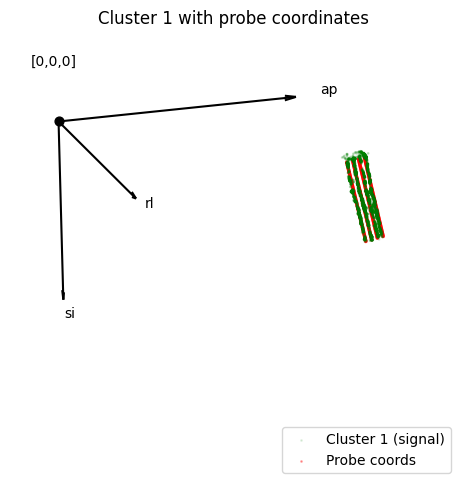

In [213]:
import matplotlib.pyplot as plt
import numpy as np

# Cluster 1 points (same as before)
cluster_pts = probe_signal_df[['k','i','j']].to_numpy(float)

# Probe coordinates
probe_pts = probe_df.downsample_coords.values

# --- Figure ---
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(1, 1, 1, projection='3d')

# Plot cluster (green)
ax.scatter(cluster_pts[:, 0], cluster_pts[:, 1], cluster_pts[:, 2],
           c='green', s=1, alpha=0.1, label='Cluster 1 (signal)')

# Plot probe (red)
ax.scatter(probe_pts[:, 2], probe_pts[:, 0], probe_pts[:, 1],
           c='red', s=1, alpha=0.3, label='Probe coords')

ax.set_title('Cluster 1 with probe coordinates')

# --- Equal aspect + arrow axes ---
def set_equal_aspect_3d(ax):
    lims = np.array([ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()])
    rng = (lims[:, 1] - lims[:, 0]).max()*2
    ax.set_xlim3d([0, rng]); ax.set_ylim3d([0, rng]); ax.set_zlim3d([0, rng])
    return rng

rng = set_equal_aspect_3d(ax)

L = 0.9 * rng
ax.quiver(0, 0, 0, L, 0, 0, color='k', arrow_length_ratio=0.05)
ax.quiver(0, 0, 0, 0, L, 0, color='k', arrow_length_ratio=0.05)
ax.quiver(0, 0, 0, 0, 0, L, color='k', arrow_length_ratio=0.05)

# Axis labels at arrow tips
ax.text(L+100, 0, 0, 'rl', color='k')
ax.text(0, L+100, 0, 'ap', color='k')
ax.text(0, 0, L+100, 'si', color='k')

# Origin
ax.scatter(0, 0, 0, c='black', s=40)
ax.text(0, -100, -300, '[0,0,0]', color='black')

# Style
ax.view_init(elev=20, azim=-20)
ax.invert_zaxis()
ax.legend(loc='lower right')
ax.axis('off')

plt.tight_layout()
plt.show()


In [63]:
surface_coords = []
for ap_slice in range(data['boundaries'].shape[0]):
    coords = np.argwhere(data['boundaries'][ap_slice,:,:]==1)
    if len(coords)==0:
        continue
    else:
        for si_slice in np.unique(coords[:,0]):
            rl_indices = np.argwhere(data['boundaries'][ap_slice,si_slice]==1)
            surface_coords.append([ap_slice,si_slice,np.min(rl_indices)]),
            surface_coords.append([ap_slice,si_slice,np.max(rl_indices)])

surface_df = pd.DataFrame(np.array(surface_coords), columns=['i','j','k'])

## plotting and animating with brainrender


In [96]:

from pathlib import Path

from myterial import orange
from rich import print

from brainrender import Animation, Scene
from brainrender.actors import Points

output_path = Path("../results/brainrender/")

scene = Scene(atlas_name="allen_mouse_10um")

regions = ["HPF"]
#scene.add_brain_region(*regions, silhouette=True, alpha=0.3)
scene.add(Points(atlas_coords,
        name="probe_1",
        colors="darkred",
        radius=50))

anim = Animation(scene, output_path, "brainrender_animation")

# Specify camera position and zoom at some key frames
# each key frame defines the scene's state after n seconds have passed
anim.add_keyframe(0, camera="frontal", zoom=1)
anim.add_keyframe(5, camera="sagittal", zoom=1)
anim.add_keyframe(10, camera="frontal", zoom=1)


# Make videos
anim.make_video(duration=10, fps=15, resetcam=True)

Saving video in ../results/brainrender

📽  Video file brainrender_animation is open... 

Output()

Saving video

Saved video at: ../results/brainrender/brainrender_animation.mp4

'../results/brainrender/brainrender_animation.mp4'

In [7]:
from brainrender import Animation, Scene, settings
from pathlib import Path

settings.SHOW_AXES = False

scene = Scene(atlas_name="allen_mouse_10um")

regions = (
    "CTX",
    "HPF",
    "STR",
    "CB",
    "MB",
    "TH",
    "HY",
)
scene.add_brain_region(*regions, silhouette=True)


def slc(scene, framen, totframes):
    # Get new slicing plane
    fact = framen / totframes
    shape_um = scene.atlas.shape_um
    # Multiply by fact to move the plane, add buffer to go past the brain
    point = [(shape_um[0] + 500) * fact, shape_um[1] // 2, shape_um[2] // 2]
    plane = scene.atlas.get_plane(pos=point, norm=(1, 0, 0))

    scene.slice(plane)


anim = Animation(
    scene, Path.cwd(), "brainrender_animation_callback", size=None
)

# Specify camera pos and zoom at some key frames`
anim.add_keyframe(0, camera="frontal", zoom=1, callback=slc)

# Make videos
anim.make_video(duration=5, fps=10, fix_camera=True)

Saving video in /ceph/behrens/georgy_antonov/Explore_exploit/experiment/code

📽  Video file brainrender_animation_callback is open... 

Output()

Saving video

Saved video at: /ceph/behrens/georgy_antonov/Explore_exploit/experiment/code/brainrender_animation_callback.mp4

'/ceph/behrens/georgy_antonov/Explore_exploit/experiment/code/brainrender_animation_callback.mp4'

In [5]:
## testing brainrender

import brainrender as br

scene = br.Scene(title="Silicon Probe Visualization", 
                 atlas_name = "allen_mouse_10um")

# Visualise the probe target regions
cp = scene.add_brain_region("CP", alpha=0.15)
rsp = scene.add_brain_region("RSP", alpha=0.15)

# Add probes to the scene.
# Each .npy file should contain a numpy array with the coordinates of each


# render
scene.export("../results/brainrender/test_brain_regions.html")

2025-08-11 15:33:37.555 ( 167.437s) [    7F7575576740]vtkXOpenGLRenderWindow.:1458  WARN| bad X server connection. DISPLAY=
[2025-08-11 15:34:54,103] INFO in helpers: Converting int64 array to int32 for JS compatibility.
[2025-08-11 15:34:54,181] INFO in helpers: Converting int64 array to int32 for JS compatibility.
[2025-08-11 15:34:54,211] INFO in helpers: Converting int64 array to int32 for JS compatibility.
[2025-08-11 15:34:54,220] INFO in helpers: Converting int64 array to int32 for JS compatibility.
[2025-08-11 15:34:54,222] INFO in helpers: Converting int64 array to int32 for JS compatibility.
[2025-08-11 15:34:54,224] INFO in helpers: Converting int64 array to int32 for JS compatibility.


The brainrender scene has been exported for web. The results are saved at 
../results/brainrender/test_brain_regions.html

'../results/brainrender/test_brain_regions.html'

In [9]:
"""
This example shows how to create an animated video by specifying
the camera parameters at a number of key frames
"""

from pathlib import Path

from brainrender import Animation, Scene

# Create a brainrender scene
scene = Scene(title="brain regions",atlas_name = "allen_mouse_10um", inset=False)

# Add brain regions
scene.add_brain_region("TH")

anim = Animation(scene, Path.cwd(), "brainrender_animation")

# Specify camera position and zoom at some key frames
# each key frame defines the scene's state after n seconds have passed
anim.add_keyframe(0, camera="top", zoom=1)
anim.add_keyframe(1.5, camera="sagittal", zoom=0.95)
anim.add_keyframe(3, camera="frontal", zoom=1)
anim.add_keyframe(4, camera="frontal", zoom=1.2)

# Make videos
anim.make_video(duration=5, fps=15, resetcam=True)

Saving video in /ceph/behrens/georgy_antonov/Explore_exploit/experiment/code

📽  Video file brainrender_animation is open... 

Output()

Saving video

Saved video at: /ceph/behrens/georgy_antonov/Explore_exploit/experiment/code/brainrender_animation.mp4

'/ceph/behrens/georgy_antonov/Explore_exploit/experiment/code/brainrender_animation.mp4'